In [1]:
"""
© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.
"""

from math import ceil
from numpy import array, empty, full, linspace, log2, pi as π
from numpy.random import default_rng
my_rng = default_rng()
std_norm = my_rng.standard_normal
rand = my_rng.random
from scipy.stats.qmc import Sobol

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

from parameter_set import ParameterSet, get_default_params, set_default_params
from reactor_modeling import spec_molar_masses, spec_names
from _reactor import (thermo_c_ideal, rxn_rate_combo, diff_bin_fuller,
                      pore_eff_thiele1, cat_geom_annularcylinder,
                      turb_Nu_Gnielinski, turb_Nu_Li, rxr_plugflow_xT)

Sources of uncertainty:
- Model form  
  - high vs. low fidelity models
  - short experimental reactor — Nu experiences entrance-region bias *(not yet enforced)*
- Parameter values  
  *adjust all of them to some degree*
- Errors in variables
  - a_cat *(not yet enforced)*
  - feed rates, $2-3$%
  - composition, $0.5$% relative error
  - temperature, $1-2$K
  - pressure, $1$%
- Instrumentation/diagnostics
  - bias — slight miss calibration, $5$% (by batch)
  - noise, $0.5$% relative error on composition

In [2]:
# Submodel selection:
thermo_c = thermo_c_ideal
rxn_rate = rxn_rate_combo
diff_bin_coeffs = diff_bin_fuller
pore_eff = pore_eff_thiele1
cat_geom = cat_geom_annularcylinder
turb_Nu_bed = turb_Nu_Gnielinski
turb_Nu_wall = turb_Nu_Li

# Nominal parameter values:
PSS = type('ParameterSetSubclass', (ParameterSet,), dict())
θ = PSS(# Thermodynamic properties:
        thermo=dict(P=(2 * 101.325e3),  # pressure [Pa]
                    R=get_default_params(thermo_c)['R']),  # gas constant
        # Chemical species & transport properties:
        spec=dict(**get_default_params(spec_molar_masses),
                  # species molar heat capacities [J / (kg K)] (C2H4, O2, C2H4O, CO2, H2O, N2)
                  heat_cap=array([2220, 988, 1622, 1025, 1902, 989]),
                  diff_bin_coeffs=get_default_params(diff_bin_coeffs),
                  k_conduct=0.0444,  # thermal conductivity of the gas [W / (m K)]
                  μ_visc=2.64e-5),  # viscosity [Pa s = kg / (s m)]
        # Chemical reaction properties & parameters:
        rxn=get_default_params(rxn_rate),
        # Turbulence parameters:
        turb_bed=get_default_params(turb_Nu_bed),  # TODO: This needs to be adjusted for entrance-region bias.
        turb_wall=get_default_params(turb_Nu_wall),
        # Catalyst properties:
        cat=dict(ρ_cat=966,  # catalyst density [kg / m^3]
                 a_cat=0.86e3,  # catalyst surface area (including pores) per mass [m^2/kg]
                 ε_void=0.71,  # as-packed void fraction (gaps-between pellets) [-]
                 cat_geom=dict(H_pellet = 2.01e-2,  # pellet height [m]
                               Do_pellet = 2.02e-2,  # pellet outer diameter [m]
                               Di_pellet = 0.97e-2),  # pellet inner diameter [m]
                 D_pore=4.8e-6,  # diameter of the pores [m]
                 L_pore=0.89e-3),  # characteristic pore length [m],
        # Reactor properties & operation:
        rxr=dict(l_reactor=2.0,  # reactor length [m]
                 r_reactor=1.956e-2,  # reactor radius [m]
                 T_cool=(200 + 273.15)))  # temperature of the cooling fluid for the reactor [K]

T_in = 200 + 273.15  # temperature [K]
Ctot = thermo_c(θ.P, T_in, θ.R)

In [3]:
# Nominal operational calculations — nomial conditions:
n_dot = 2 / 12.8 * array([2.68, 3.05, 0, 0, 0, 42.4]) * 1e-4  # molar feed rates — single tube [mol/s]
x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
Q_in = n_dot.sum() / Ctot  # volumetric feed rates — single tube [m^3/s]
A_tube = π * θ.r_reactor**2  # single-reactor-tube cross-sectional area [m^2]
u_in = Q_in / A_tube  # superficial velocity [m/s]# Run the coupled model:
n_z = 600

/Users/smith_sean/Documents/ConglomerateUQ/ToyProblem-EthyleneOx/_reactor.py:343: RuntimeWarning: divide by zero encountered in true_divide
  ε_film = rxn_rate / (ε_pore * rxn_rateδ)


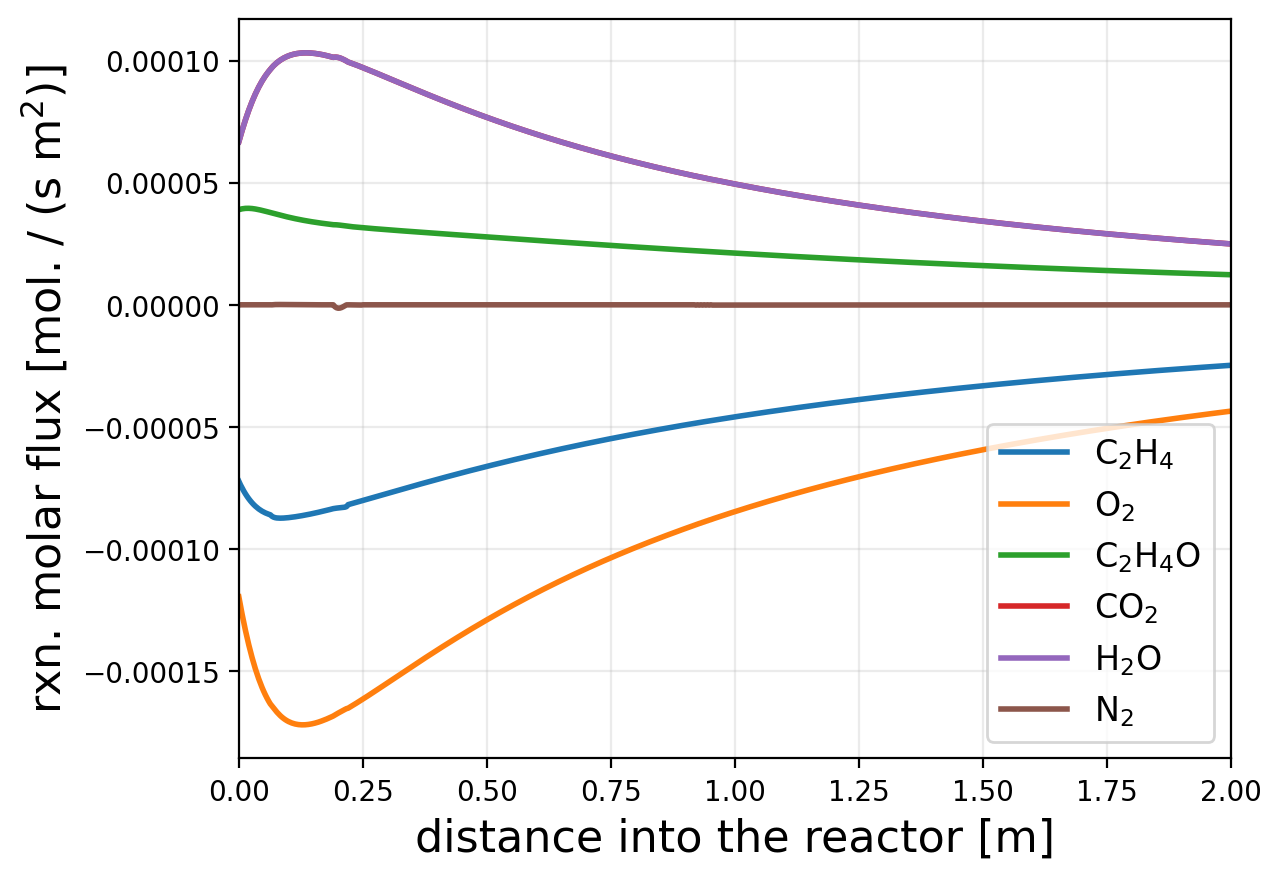

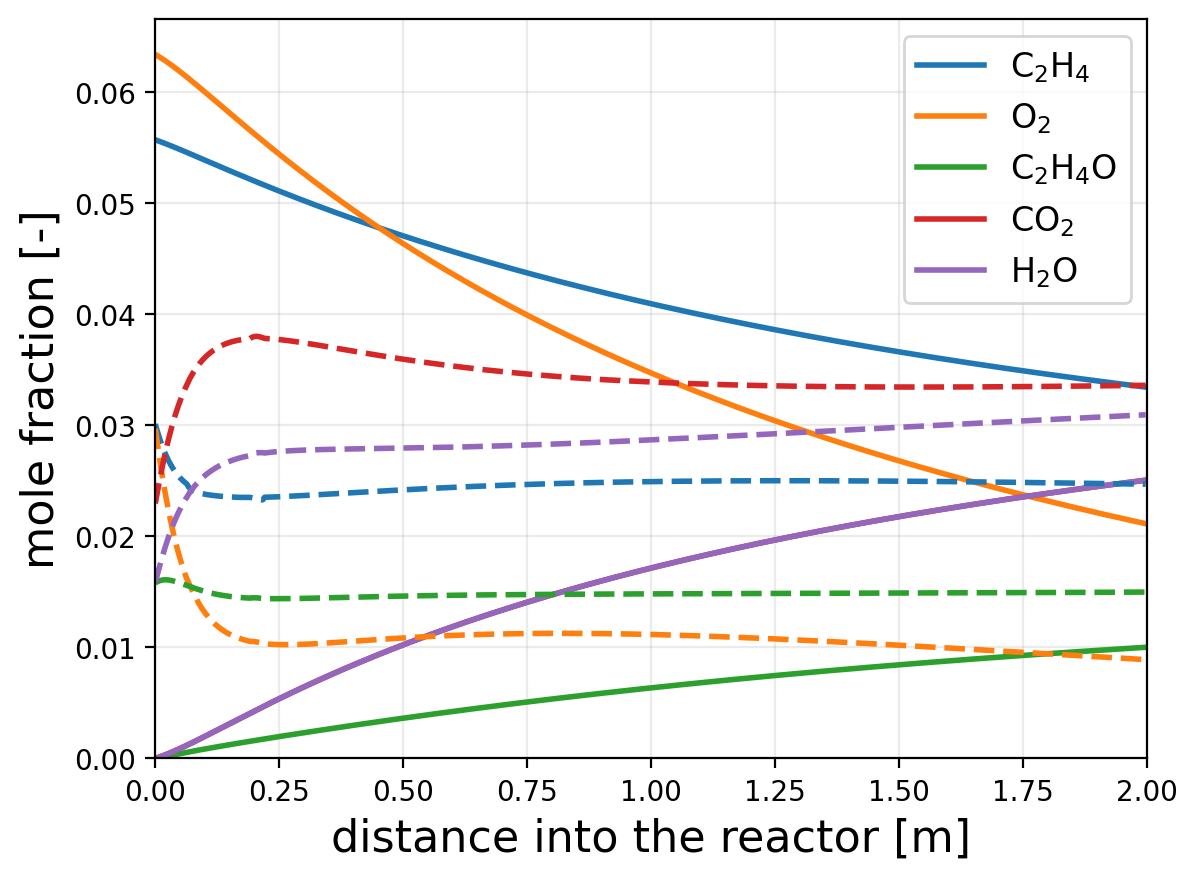

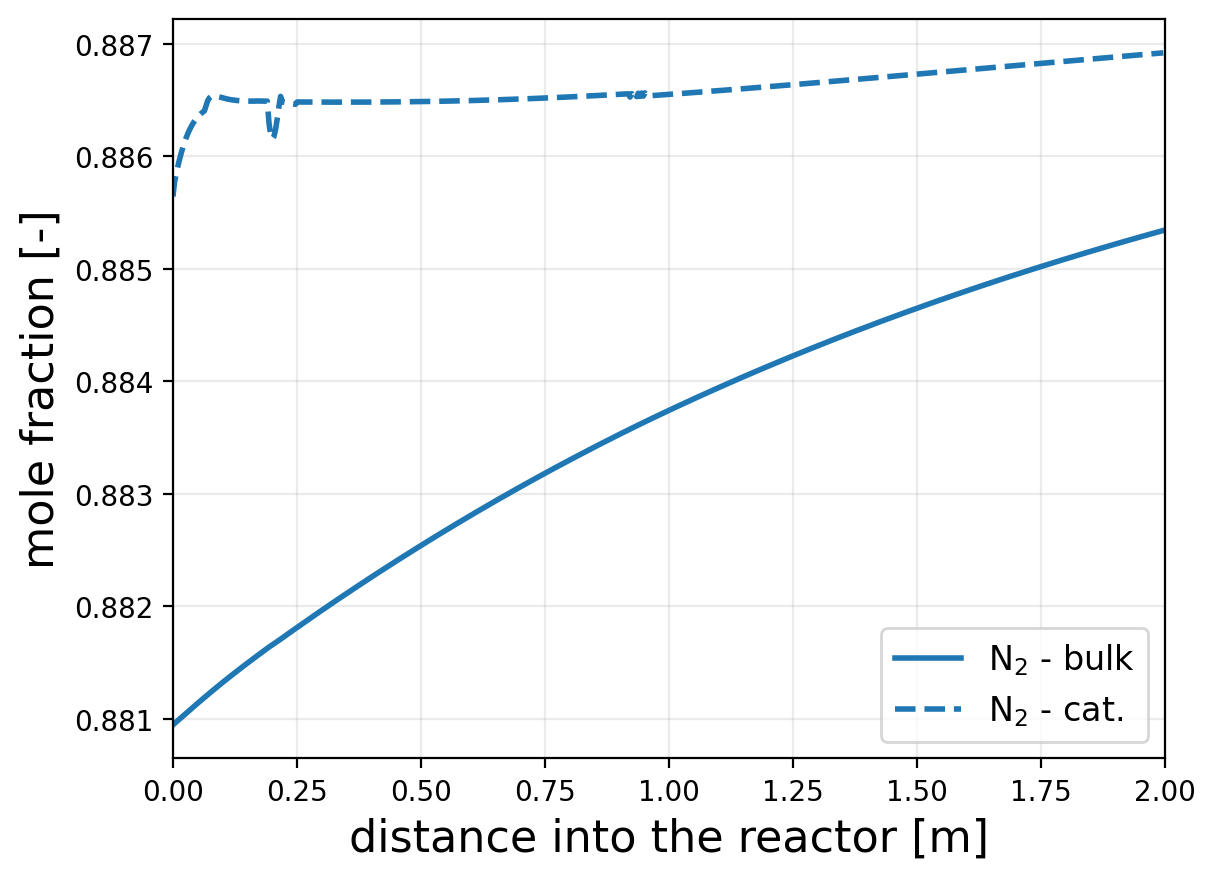

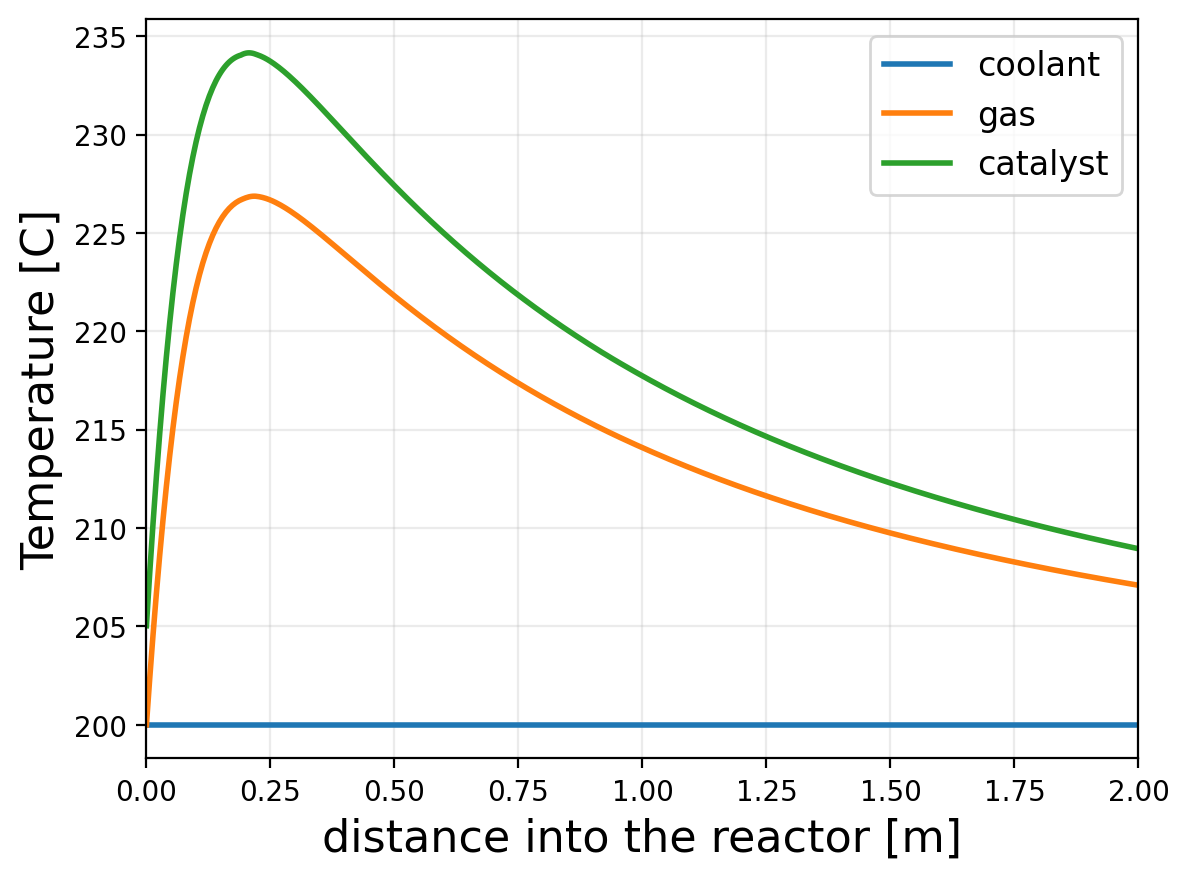

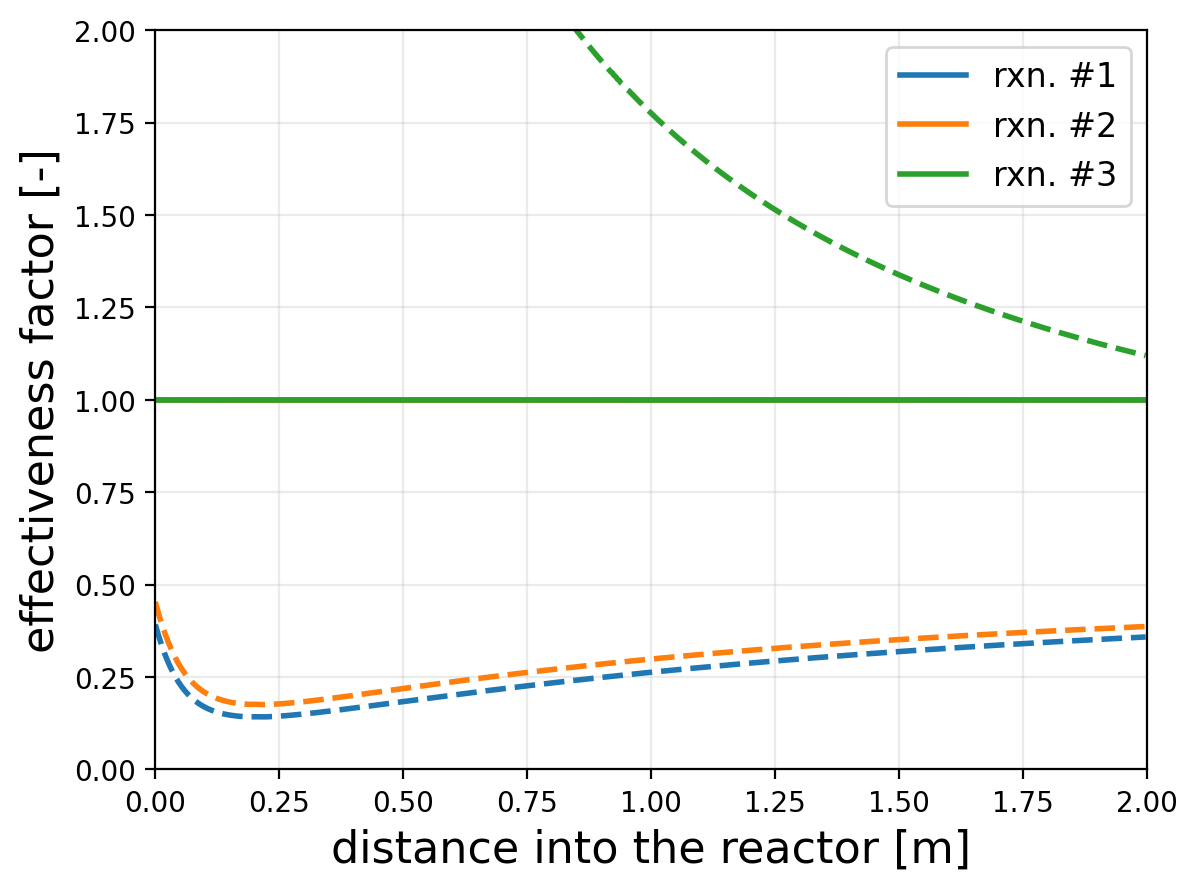

In [4]:
# Run the coupled model — nominal conditions:
out = rxr_plugflow_xT(x_in, T_in, u_in, thermo_c, rxn_rate, diff_bin_coeffs, pore_eff,
                    cat_geom, turb_Nu_bed, turb_Nu_wall, θ, n_z)
Zrxr, Nrxr, Xrxr, Trxr, Ncat, Xcat, Tcat, ε_film, ε_pore = out

# Plot the results:
plt.figure()
plt.plot(Zrxr[:-1], Ncat[:-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
# plt.plot(Zrxr[1:], Xcat[1:, :-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('rxn. molar flux [mol. / (s m$^2$)]', fontsize=16)
plt.legend(spec_names, fontsize=12)

plt.figure()
plt.plot(Zrxr, Xrxr[:, :-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], Xcat[:-1, :-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('mole fraction [-]', fontsize=16)
plt.legend(spec_names[:-1], fontsize=12)

plt.figure()
plt.plot(Zrxr, Xrxr[:, -1], linestyle='-', linewidth=2.0, label='N$_2$ - bulk')
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], Xcat[:-1, -1], linestyle='--', linewidth=2.0, label='N$_2$ - cat.')
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('mole fraction [-]', fontsize=16)
plt.legend(fontsize=12)

plt.figure()
plt.plot([Zrxr[0], Zrxr[-1]], [θ.T_cool - 273.15, θ.T_cool - 273.15],
        linewidth=2.0, label='coolant')
plt.plot(Zrxr, Trxr - 273.15, linewidth=2.0, label='gas')
plt.plot(Zrxr[:-1], Tcat[:-1] - 273.15, linewidth=2.0, label='catalyst')
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
# plt.ylim(0, None)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('Temperature [C]', fontsize=16)
plt.legend(fontsize=12)

plt.figure()
plt.plot(Zrxr[:-1], ε_pore[:-1], linestyle='-', linewidth=2.0)
plt.gca().set_prop_cycle(None)
plt.plot(Zrxr[:-1], ε_film[:-1], linestyle='--', linewidth=2.0)
plt.grid(True, alpha=0.25)
plt.xlim(Zrxr[0], Zrxr[-1])
plt.ylim(0, 2)
plt.xlabel('distance into the reactor [m]', fontsize=16)
plt.ylabel('effectiveness factor [-]', fontsize=16)
plt.legend([f'rxn. #{i + 1}' for i in range(rxn_rate.n_rxn)], fontsize=12) ;

In [ ]:
# Set up a design of experiments:
n_dsgn = 5

# # Illustrative design — changes only velocity, u_in:
# design = full(shape=(n_dsgn, 4), fill_value=0.5)
# design[:, 3] = linspace(0, 1, n_dsgn)

# More useful design:
m_dsgn = ceil(log2(n_dsgn))
n_dsgn = 2**m_dsgn # round up to the nearest power of 2
my_sobol = Sobol(d=4, scramble=True)
design = my_sobol.random_base2(m=m_dsgn)

print(design)

In [ ]:
# Execute a design and return the results
# Scenario-parameter ranges
Xeth_min = 6.0e-2
Xeth_max = 6.5e-2
Xoxy_min = 5.0e-2
Xoxy_max = 6.0e-2
T_min = 470
T_max = 500
u_min = 1.21e-2
u_max = 7.77e-2
θs_ref = dict(P=θ.P, T_cool=θ.T_cool, a_cat=θ.a_cat)

# Applied intrument errors
σ_N = 2.0  # percent relative error (normal, iid) on total molar-flux measurement [-]
δ_x = 2.0  # percent relative error (normal, fixed bias) on mole fractions [-]
σ_x = 0.5  # percent relative error (normal, iid w/ renormalization) on mole fractions [-] 
σ_T = 1.5  # absolute error (normal, iid) on temperature measurement [K]
σ_P = 1.0  # relative error (normal, iid) on pressure [-]
δ_x_fixed = δ_x / 100 * std_norm(5)

# Numerical parameter
n_z = 600

expt = []
for i in range(n_dsgn):
    print(i)
    Xeth = Xeth_min + (Xeth_max - Xeth_min) * design[i, 0]
    Xoxy = Xoxy_min + (Xoxy_max - Xoxy_min) * design[i, 1]
    x0 = array([Xoxy, Xeth, 0, 0, 0, 1 - (Xoxy + Xeth)])
    x0[:5] = (1 - σ_x / 100 * std_norm(5)) * x0[:5]  # information from multiple sources eleminates bias
    x0 /= x0.sum()
    T0 = T_min + (T_max - T_min) * design[i, 2]
    T0 -= σ_T * std_norm()
    u0 = u_min + (u_max - u_min) * design[i, 3]
    u0 *= 1 - σ_N / 100 * std_norm()
    θ.P = (1 - σ_P / 100 * std_norm()) * θs_ref['P']
    θ.T_cool = T0
    # θ.a_cat = 
    # n_z = 
    
    out = rxr_plugflow_xT(x0, T0, u0, thermo_c, rxn_rate, diff_bin_coeffs, pore_eff,
                          cat_geom, turb_Nu_bed, turb_Nu_wall, θ, n_z)
    Zrxr, Nrxr, Xrxr, Trxr, Ncat, Xcat, Tcat, ε_film, ε_pore = out
    # y_out = dict(Ntot=Nrxr[-1].sum(), x=Xrxr[-1], T=Trxr[-1])
    # print('   ', y_out)
    
    N_meas = (1 + σ_N / 100 * std_norm()) * Nrxr[-1].sum()
    x_meas = Xrxr[-1].copy()
    x_meas[:5] = (1 + σ_x / 100 * std_norm(5) + δ_x_fixed) * x_meas[:5]
    x_meas /= x_meas.sum()
    T_meas = Trxr[-1] + σ_T * std_norm()
    y_meas = dict(Ntot=N_meas, x=x_meas, T=T_meas)
    
    expt.append(dict(scenario=dict(x=x0, T=T0, u=u0),
                     outcome=dict(x=x_meas, T=T_meas, N=N_meas)))

# Check for any red flags:
print(expt)

In [ ]:
# # Just for the example in which only u_in changes
# u_expt = empty(n_dsgn)
# x_expt = empty((n_dsgn, 6))
# for i in range(n_dsgn):
#     u_expt[i] = expt[i]['scenario']['u']
#     x_expt[i] = expt[i]['outcome']['x']

# plt.plot(u_expt, x_expt[:, :-1], linestyle='none', marker='o')
# plt.gca().set_prop_cycle(None)
# plt.plot(u_expt, x_expt[:, :-1], alpha=0.05)
# plt.ylim(0, None)
# plt.xlabel('scenario superficial velocity, u$_{in}$ [m/s]', fontsize=16)
# plt.ylabel('expt. composition out, x$_{expt}$ [-]', fontsize=16)
# plt.legend(spec_names[:-1], fontsize=12)
# plt.grid(True, alpha=0.15) ;

In [ ]:
# Save the experimental results to a pickle file:
from pickle import dump
file_name = 'expt_integrated.p'
with open(file_name, 'wb') as file_obj:
    dump(expt, file_obj)

In [ ]:
# Import the experimental results from their pickle file:
from pickle import load
file_name = 'expt_integrated.p'
with open(file_name, 'rb') as file_obj:
    expt_data = load(file_obj)

# Check for any red flags:
n_dsgn = len(expt_data)
print(expt_data)

In [ ]:
# Compare each experiment to the model, run at each of the same conditions (apples to apples):
import matplotlib.pyplot as plt
from reactor_modeling import (thermo_c_ideal, spec_names, spec_molar_masses, mix_molar_mass,
                              rxn_rate_Klugherz, calc_spec_rates, pore_eff_thiele1,
                              cat_geom_sphere, trans_Re, trans_Pr, trans_Sc,
                              turb_Nu_text, film_flux_x, rxr_plugflow_x)
from parameter_set import ParameterSet, get_default_params, set_default_params

# Submodel selections:
thermo_c = thermo_c_ideal
rxn_rate = rxn_rate_Klugherz
pore_eff = pore_eff_thiele1
cat_geom = cat_geom_sphere
turb_Nu = turb_Nu_text

# Parameter values:
PSS1= type('ParameterSetSubclass1', (ParameterSet,), dict())
θ = PSS1(# Thermodynamic properties:
        thermo=dict(P=(2 * 101.325e3),  # pressure [Pa]
                    T=(200 + 273.15),  # Temperature [K]
                    **get_default_params(thermo_c_ideal)),
        # Chemical species properties:
        spec=dict(**get_default_params(spec_molar_masses),
                    D = array([2.0e-5, 2.6e-5, 1.7e-5, 2.1e-5, 3.3e-5, 2.4e-5]),  # diff. coefs.
                    μ_visc=2.6e-5),  # viscosity [Pa s = kg / (s m)]
        # Chemical reaction properties & parameters:
        rxn=get_default_params(rxn_rate),
        # Turbulence parameters:
        turb_bed=get_default_params(turb_Nu),
        # Catalyst properties:
        cat=dict(ρ_cat=881,  # catalyst density [kg / m^3]
                 a_cat=0.8e3,  # catalyst surface area (including pores) per mass [m^2/kg]
                 ε_void=0.75,  # as-packed void fraction (gaps-between pellets) [-]
                 cat_geom=dict(D_pellet=2e-2),  # pellet diameter [m]
                 D_pore=4e-6,  # diameter of the pores [m]
                 # D_pore = 40e-9,  # diameter of the pores [m]  # WARNING: for testing only!
                 L_pore=1e-3),  # characteristic pore length [m],
        # Reactor properties & operation:
        rxr=dict(l_rxr=12.8,  # reactor length (industrial reactor) [m]
                 # l_rxr=2.0,  # reactor length (laboratory reactor) [m]
                 r_rxr=1.956e-2))

# Run the coupled model at each of the experimental conditions:
n_z = 600
x_model = empty((n_dsgn, 6))
N_model = empty(n_dsgn)
for i in range(n_dsgn):
    print(i)
    θ.T = expt_data[i]['scenario']['T']
    out = rxr_plugflow_x(expt_data[i]['scenario']['x'], expt_data[i]['scenario']['u'],
                         thermo_c, rxn_rate, pore_eff, cat_geom, turb_Nu, θ, n_z)
    Zrxr, Nrxr, Xrxr, Ncat, Xcat, ε_film, ε_pore = out
    x_model[i] = Xrxr[-1]
    N_model[i] = Nrxr[-1].sum()

# # Plot the results — for the illustrative example:
# plt.figure()
# plt.plot(u_expt, x_expt[:, :-1], linestyle='none', marker='o')
# plt.gca().set_prop_cycle(None)
# plt.plot(u_expt, x_model[:, :-1])
# plt.ylim(0, None)
# plt.xlabel('scenario superficial velocity, u$_{in}$ [m/s]', fontsize=16)
# plt.ylabel('expt. composition out, x$_{expt}$ [-]', fontsize=16)
# plt.legend(spec_names[:-1], fontsize=12)
# plt.grid(True, alpha=0.15) ;